In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

In [2]:
filename = 'data/oh3573s2_blue_red_channels.ts'
with open(filename, 'r') as fin:
    # human text line
    fin.readline()
    # header info line
    headers = fin.readline()
    # spectral channels timeseries
    data = fin.readlines()

In [3]:
for cntr, line in enumerate(data):
    if cntr < 1:
        file_data = np.array(line.strip().split(',')[:-1], dtype=float)
    else:
        file_data = np.vstack([file_data, np.array(line.strip().split(',')[:-1], dtype=float)])

velocities = np.array([vel.strip() for vel in headers.split(',')[1:]], dtype=float)
timestamps = file_data[:,0]
spectra = file_data[:,1:]
[nts, nch] = spectra.shape

### Fitting smoothing functions to detrend data

**Savitzky Golay**   
The Savitzky Golay filter is a particular type of low-pass digital filter, well adapted for data smoothing. 

The Savitzky–Golay filter can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the precision of the data without distorting the signal tendency. This is achieved, in a process known as convolution, by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares. 

Algorithm is described below, suggested application is the SciPy signal filter function    
https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html

**Note**: Important caviat is always to choose the window_size as an odd number

```
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')
```

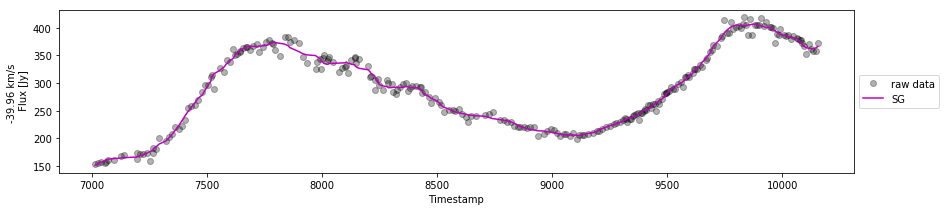

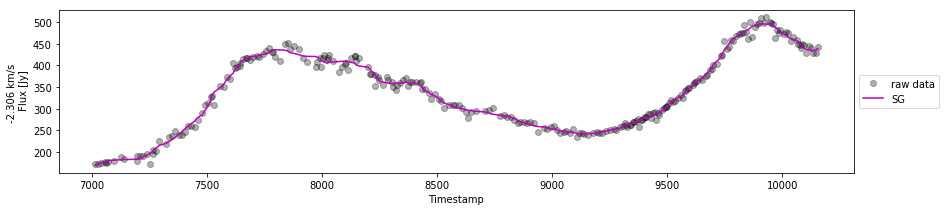

In [4]:
from scipy.signal import savgol_filter as savitzky_golay
for channel in range(nch):
    plt.figure(figsize=(15,3), facecolor='white')
    ax = plt.subplot(111)
    ax.plot(timestamps, spectra[:, channel], 'ko', alpha=0.3, label='raw data')
    # Apply a Savitzky-Golay filter to an array.
    plt.plot(timestamps, savitzky_golay(spectra[:, channel], 21, 3), 'm-', label='SG')
    # Shrink current axis by 5%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('{} km/s \n Flux [Jy]'.format(velocities[channel]))
    ax.set_xlabel('Timestamp')

**1D interpolation**   
The `interp1d` class in the `scipy.interpolate` is a convenient method to create a function based on fixed data points, which can be evaluated anywhere within the domain defined by the given data using linear interpolation.

Types of the interpolation techniques: `'Linear', 'Nearest', 'Zero', 'Slinear', 'Quadratic', 'Cubic'`

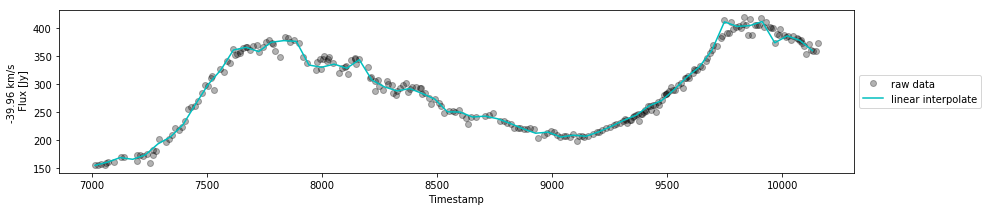

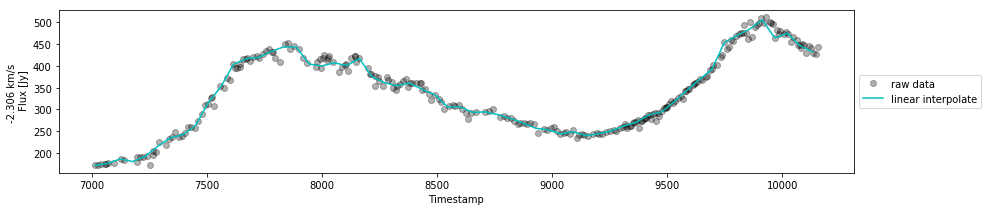

In [5]:
from scipy.interpolate import interp1d
def polynomial_fit(x, y, kind='linear'):
    step = np.diff(x).max()
    start = x.min()
    stop = x.max()
    xx = np.arange(start, stop, step)
    
    f = interp1d(x, y, kind='linear')

    return [xx, f(xx)]

for channel in range(nch):
    plt.figure(figsize=(15,3), facecolor='white')
    ax = plt.subplot(111)
    ax.plot(timestamps, spectra[:, channel], 'ko', alpha=0.3, label='raw data')
    # Simple interpolation
    poly_ts, poly_fit = polynomial_fit(timestamps, spectra[:, channel])
    plt.plot(poly_ts, poly_fit, 'c-', label='linear interpolate')
    # Shrink current axis by 5%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_ylabel('{} km/s \n Flux [Jy]'.format(velocities[channel]))
    ax.set_xlabel('Timestamp')

**Fitting a smoothing spline to the data**   
To draw smooth curves through data points, drafters once used thin flexible strips of wood, hard rubber, metal or plastic called mechanical splines. To use a mechanical spline, pins were placed at a judicious selection of points along a curve in a design, and then the spline was bent, so that it touched each of these pins.

Clearly, with this construction, the spline interpolates the curve at these pins. It can be used to reproduce the curve in other drawings. The points where the pins are located is called knots. We can change the shape of the curve defined by the spline by adjusting the location of the knots.

In [6]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

from scipy.interpolate import UnivariateSpline
def smoothing_spline(x, y, step=None, win=None):

    start = x.min()
    stop = x.max()
    if step is None:
        step = np.diff(x).max()
    xx = np.arange(start, stop, step)
    
    if win is not None:
        x = running_mean(x, win)
        y = running_mean(y, win)
    
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(0.9)
    
    return [xx, spl(xx)]

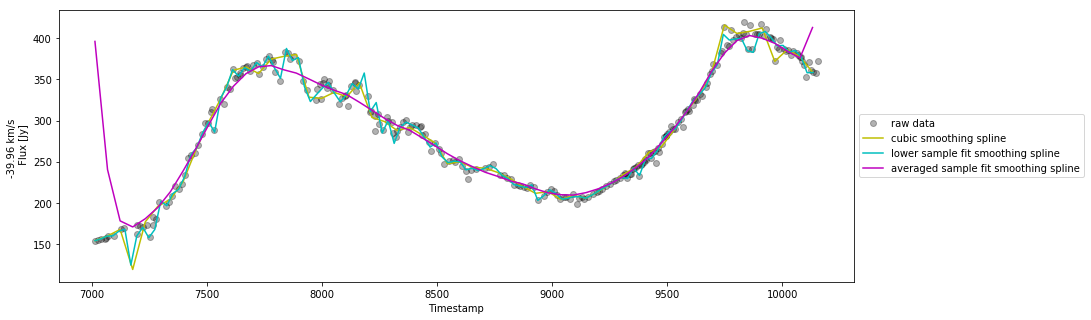

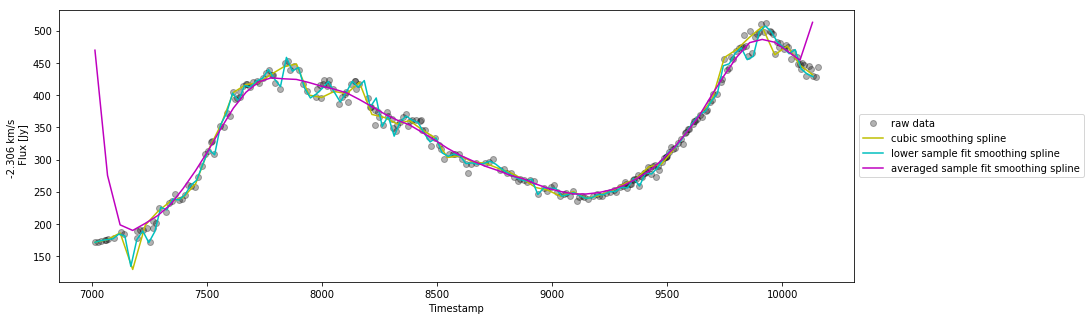

In [7]:
for channel in range(nch):
    plt.figure(figsize=(15,5), facecolor='white')
    ax = plt.subplot(111)
    ax.plot(timestamps, spectra[:, channel], 'ko', alpha=0.3, label='raw data')
    # Cubic smoothing spline over short delta times, oversampled and noisy fit
    ts, spline_fit = smoothing_spline(timestamps, spectra[:, channel])
    plt.plot(ts, spline_fit, 'y-', label='cubic smoothing spline')
    # Cubic smoothing spline over larger delta times, looses the data trend in smoothing process
    step = int(len(timestamps)*0.1)  # use every 10th data point
    ts, spline_fit = smoothing_spline(timestamps, spectra[:, channel], step=step)
    plt.plot(ts, spline_fit, 'c-', label='lower sample fit smoothing spline')
    # Use a running mean to compute smoothed values to fit, but needs extrapolation at the ends
    ts, spline_fit = smoothing_spline(timestamps, spectra[:, channel], win=21)
    plt.plot(ts, spline_fit, 'm-', label='averaged sample fit smoothing spline')

    # Shrink current axis by 5%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_ylabel('{} km/s \n Flux [Jy]'.format(velocities[channel]))
    ax.set_xlabel('Timestamp')

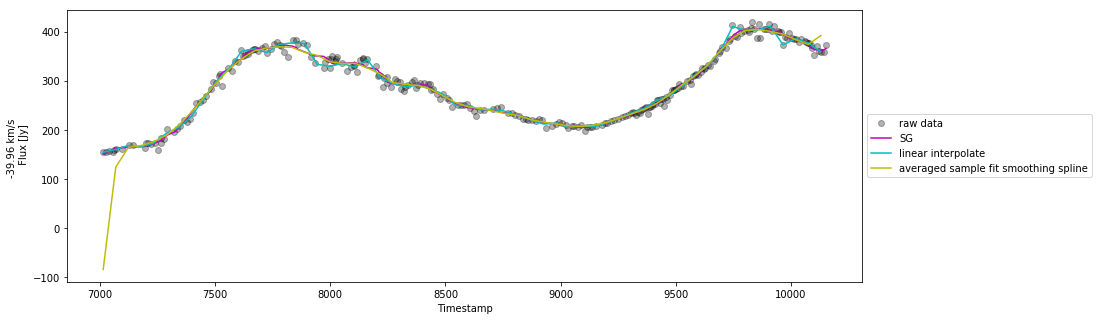

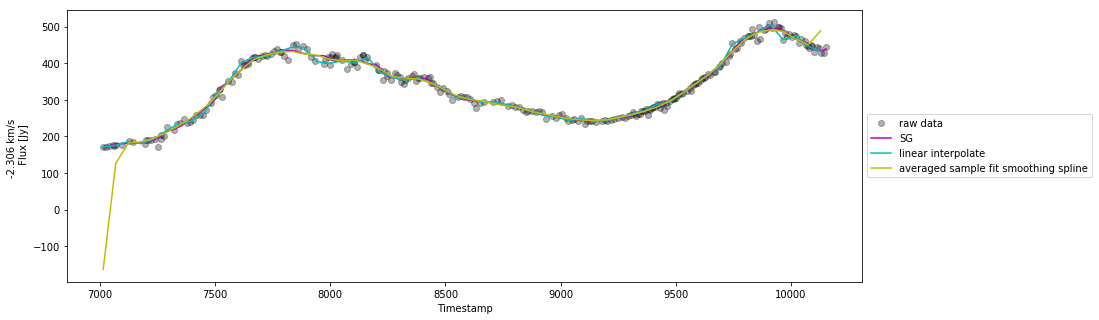

In [8]:
for channel in range(nch):
    plt.figure(figsize=(15,5), facecolor='white')
    ax = plt.subplot(111)
    ax.plot(timestamps, spectra[:, channel], 'ko', alpha=0.3, label='raw data')
    # Apply a Savitzky-Golay filter to an array.
    plt.plot(timestamps, savitzky_golay(spectra[:, channel], 21, 3), 'm-', label='SG')
    # Simple interpolation
    poly_ts, poly_fit = polynomial_fit(timestamps, spectra[:, channel])
    plt.plot(poly_ts, poly_fit, 'c-', label='linear interpolate')
    # Cubic smoothing spline over smoothed values to fit
    ts, spline_fit = smoothing_spline(timestamps, spectra[:, channel], win=13)
    plt.plot(ts, spline_fit, 'y-', label='averaged sample fit smoothing spline')

    # Shrink current axis by 5%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('{} km/s \n Flux [Jy]'.format(velocities[channel]))
    ax.set_xlabel('Timestamp')

**Results**   
Linear interpolation and cubic spline fits are not as smooth as the SG filter. To smooth the fit, a windowing running mean can be applied that mimics the SG results.

Considerations are that the ends of the data has to be approximated using extrapolation (leading to unknown errors), as well as the fact that the windowing adds more parameters to be adjusted by the user and rather not prefered for general application

Thus the SG filter is a good choice for smoothing this sampled data